In [1]:
import numpy as np
import struct
from xgrads import open_CtlDataset 
# import pandas as pd
# import xarray as xr
# import geopandas as gpd
# import regionmask, struct
import matplotlib.pyplot as plt
import rioxarray
from pyproj import Transformer
import cartopy.crs as ccrs

In [2]:
obj = ccrs.LambertAzimuthalEqualArea(105, 47)
obj_proj = obj.to_string()

obj_proj = 'EPSG:3408'

transformer = Transformer.from_crs('EPSG:4326', obj_proj)
transformer_inv = Transformer.from_crs(obj_proj, 'EPSG:4326')

workplace = './'

In [3]:
icesheet = rioxarray.open_rasterio('IceMask01.asc').rio.write_crs(obj_proj)

# icesheet = icesheet.rio.reproject('EPSG:4326')

In [4]:
drang = rioxarray.open_rasterio('PanArcticMask01.asc').rio.write_crs(obj_proj)

In [5]:
basin = rioxarray.open_rasterio('DrainageBasinMask01.asc').rio.write_crs(obj_proj)

#  Processsing Vegetation ...

In [6]:
vege = rioxarray.open_rasterio('temveg2arctic1999.ease.asc').rio.write_crs(obj_proj) #.rio.write_nodata(-9999, inplace=True)#.rio.reproject('EPSG:4326')

vege.values[icesheet.values == 1] = -9999 # ocean
vege.values[icesheet.values == 2] = -9999 # ice
vege.values[icesheet.values == -9999] = -9999 # nodata

vege.values[drang.values == 0] = -9999
vege.values[drang.values == 1] = -9999
vege.values[drang.values == -9999] = -9999

vege.values[vege.values ==  0] = -9999
vege.values[vege.values ==  9] = -9999
vege.values[vege.values == 10] = -9999

# vege.values[(~np.isin(basin.values, [5])) & (~np.isin(basin.values, [4])) & (~np.isin(basin.values, [3]))] = -9999
vege.values[(~np.isin(basin.values, [5]))] = -9999


# vege.values[~np.where((basin.values == 4) or (basin.values == 5))] = -9999

# aaa = 5E6
# bbb = 3.75E6
# ccc = -aaa
# ddd = -bbb

maxx = 3.9E6
maxy = 2.7E6
minx = 1.4E6
miny = 0.5E6

# maxx = 4.85E6
# maxy = 2.75E6
# minx = 1.45E6
# miny = -2.05E6

vege = vege.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy,
)

vege_proj = vege.rio.reproject('EPSG:4326')

print(np.sum(vege.values > 0))

np.unique(vege.values.flatten())

3910


array([-9999,     2,     3,     4,     5], dtype=int32)

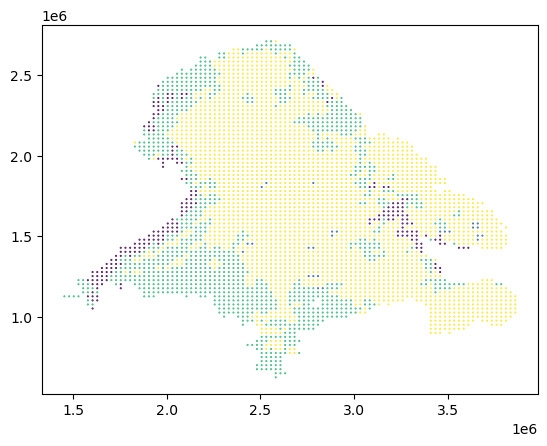

In [7]:
lon, lat = np.meshgrid(vege.x, vege.y)
plt.scatter(lon[vege.values[0,:,:]>0], lat[vege.values[0,:,:]>0], 
            c = vege.values[0,:,:][vege.values[0,:,:]>0], 
            s=0.25)

In [8]:
vege00 = vege.copy()
vege00.values[vege.values == -9999] = 24
vege00.rio.to_raster('vege.asc')

#  Processsing Topography ...

In [9]:
topo = rioxarray.open_rasterio('g_mean.asc').rio.write_crs(obj_proj) #.rio.write_nodata(-9999, inplace=True)#.rio.reproject('EPSG:4326')

topo.values[icesheet.values == 1] = -9999 # ocean
topo.values[icesheet.values == 2] = -9999 # ice
topo.values[icesheet.values == -9999] = -9999 # nodata

topo.values[drang.values == 0] = -9999
topo.values[drang.values == 1] = -9999
topo.values[drang.values == -9999] = -9999

# aaa = 5E6
# bbb = 3.75E6

topo = topo.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy,
)

topo.values[vege.values ==  0] = -9999
topo.values[vege.values ==  9] = -9999
topo.values[vege.values == 10] = -9999
topo.values[vege.values == -9999] = -9999

topo.values = np.floor(topo.values)

topo_proj = topo.rio.reproject('EPSG:4326')

print(np.sum(topo.values > 0))

topo

3910


<xarray.DataArray (band: 1, y: 89, x: 101)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.404e+06 1.429e+06 ... 3.885e+06 3.911e+06
  * y            (y) float64 2.707e+06 2.682e+06 ... 5.264e+05 5.014e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

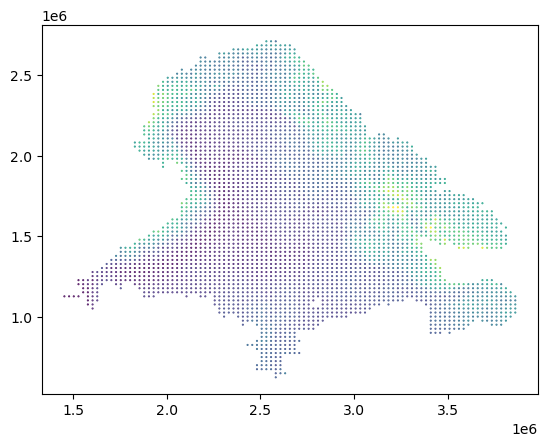

In [10]:
xxx, yyy = np.meshgrid(topo.x, topo.y)
plt.scatter(xxx[topo.values[0,:,:]>0], yyy[topo.values[0,:,:]>0], 
            c = topo.values[0,:,:][topo.values[0,:,:]>0], 
            s=0.25)

lat_max=73.15 lat_min=52.60
lon_max=141.33 lon_min=103.60


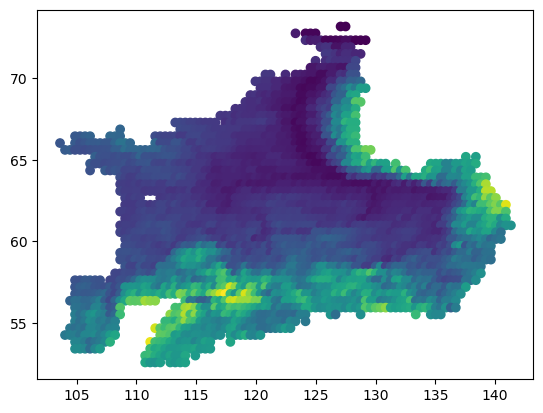

In [11]:
lon2, lat2 = np.meshgrid(topo_proj.x, topo_proj.y)
plt.scatter(lon2[topo_proj.values[0,:,:]>0], lat2[topo_proj.values[0,:,:]>0], c = topo_proj.values[0,:,:][topo_proj.values[0,:,:]>0])

print("lat_max={:0.2f}".format(lat2[topo_proj.values[0,:,:]>0].max()), 
      "lat_min={:0.2f}".format(lat2[topo_proj.values[0,:,:]>0].min()))

print("lon_max={:0.2f}".format(lon2[topo_proj.values[0,:,:]>0].max()), 
      "lon_min={:0.2f}".format(lon2[topo_proj.values[0,:,:]>0].min()))

In [12]:
topo00 = topo.copy()
topo00.values[topo.values == -9999] = 0
topo00.rio.to_raster('topo.asc')

(89, 101) 152.59242456218163
(89, 101) 76.56422893265864


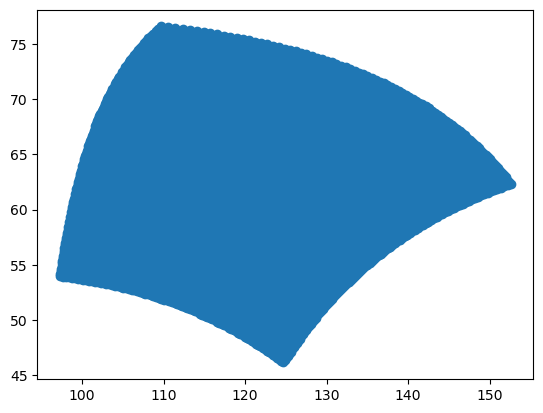

In [13]:
lat, lon = transformer_inv.transform(xxx, yyy)

print(lon.shape, lon.max())
print(lat.shape, lat.max())

plt.scatter(lon, lat)

xx00 = topo.copy()
xx00.values[0,:,:] = lon + 0.0
xx00.rio.to_raster('../extra_met/grid_lon.asc')

yy00 = topo.copy()
yy00.values[0,:,:] = lat + 0.0
yy00.rio.to_raster('../extra_met/grid_lat.asc')

In [14]:
%run ../../utils/asc_topo_veg_to_grads.py topo.asc vege.asc topo_vege.gdat

%run ../../utils/asc_to_grads.py ../extra_met/grid_lat.asc ../extra_met/grid_lat.gdat
%run ../../utils/asc_to_grads.py ../extra_met/grid_lon.asc ../extra_met/grid_lon.gdat

['../../utils/asc_topo_veg_to_grads.py', 'topo.asc', 'vege.asc', 'topo_vege.gdat']


/opt/miniforge/lib/python3.10/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/opt/miniforge/lib/python3.10/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Var

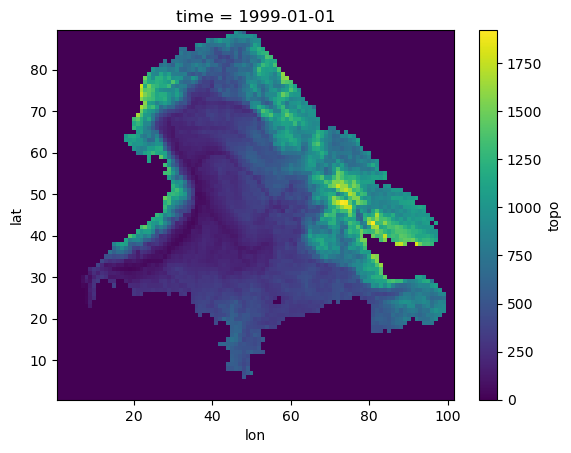

In [15]:
tz0 = open_CtlDataset('topo_vege.ctl')

tz0.topo.plot()

/opt/miniforge/lib/python3.10/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,


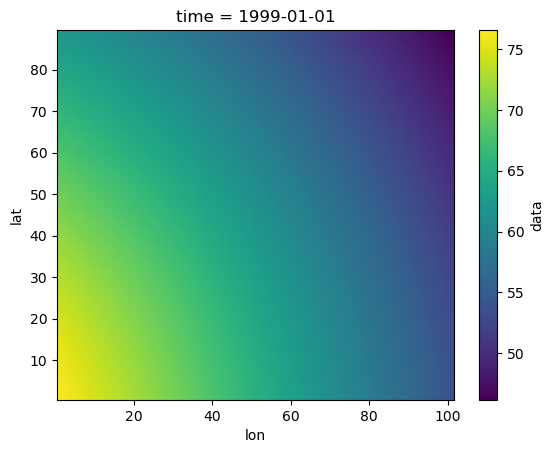

In [16]:
tz1 = open_CtlDataset('../extra_met/grid_lat.ctl')

tz1.data.plot()

/opt/miniforge/lib/python3.10/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,


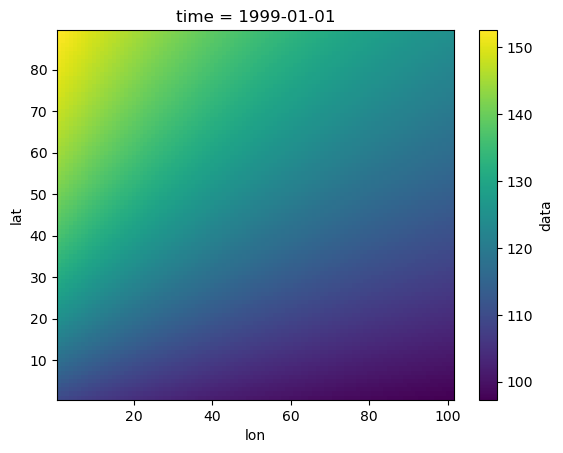

In [17]:
tz2 = open_CtlDataset('../extra_met/grid_lon.ctl')

tz2.data.plot()